## BBC NEWS TEXT CLASSIFICATION PROBLEM

In [1]:
# Importing Required Libraries

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
#nltk.download('punkt')
#nltk.download('stopwords')
#nltk.download('wordnet')
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud ,STOPWORDS

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Importing Given Dataset

bbc_df = pd.read_csv("BBC.csv")

bbc_df.head()

,No,News,Category
0,1,Ad sales boost Time Warner profit Quarterly p...,business
1,2,Dollar gains on Greenspan speech The dollar h...,business
2,3,Yukos unit buyer faces loan claim The owners ...,business
3,4,High fuel prices hit BA's profits British Air...,business
4,5,Pernod takeover talk lifts Domecq Shares in U...,business


### DATA EXPLORATION

In [3]:
# Describing dataset

print('\033[1mSHAPE OF BBC DATASET: \033[0m', bbc_df.shape, 
      '\033[1m\n\n\nCOLUMNS IN BBC DATASET: \033[0m', bbc_df.columns, 
      '\033[1m\n\n\nUNIQUE CATEGORIES: \033[0m', bbc_df.Category.unique(), 
      '\033[1m\n\n\nRANDOM DATA SAMPLE: \n\n\033[0m', bbc_df.sample(n=7),
      '\033[1m\n\n\nDATA TYPE: \n\033[0m', bbc_df.dtypes,
      '\033[1m\n\n\nCHECKING FOR NULL VALUES: \n\033[0m', bbc_df.isna().sum(),'\n\n')

SHAPE OF BBC DATASET:  (2225, 3) 


COLUMNS IN BBC DATASET:  Index(['No', 'News', 'Category'], dtype='object') 


UNIQUE CATEGORIES:  ['business' 'entertainment' 'politics' 'sport' 'tech'] 


RANDOM DATA SAMPLE: 

         No                                               News       Category
1309  1310  Blair 'up for it' ahead of poll  Tony Blair sa...       politics
1200  1201  Labour battle plan 'hides Blair'  The Tories h...       politics
702    703  CSI shows give 'unrealistic view'  People have...  entertainment
427    428  Karachi stocks hit historic high  The Karachi ...       business
1325  1326  Kenya lift Chepkemei's suspension  Kenya's ath...          sport
2042  2043  Disney backs Sony DVD technology  A next gener...           tech
23      24  US trade gap hits record in 2004  The gap betw...       business 


DATA TYPE: 
 No           int64
News        object
Category    object
dtype: object 


CHECKING FOR NULL VALUES: 
 No          0
News        0
Category    0
dtype: in

NUMBER OF SAMPLES IN EACH OF THE NEWS CATEGORY: 



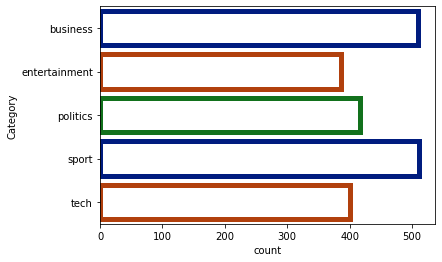

In [4]:
# Plotting number of samples within each category

print('NUMBER OF SAMPLES IN EACH OF THE NEWS CATEGORY: \n')
sns.countplot(y=bbc_df.Category,facecolor=(0, 0, 0, 0),linewidth=5,edgecolor=sns.color_palette("dark", 3))
plt.show()

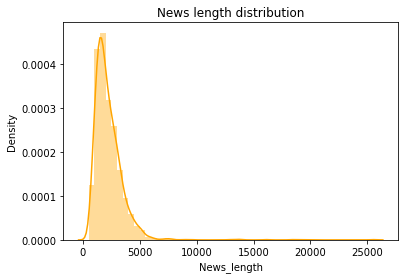

In [5]:
# Visualizing Length/ word count of News

bbc_df['News_length'] = bbc_df['News'].str.len()
sns.distplot(bbc_df['News_length'],color='orange').set_title('News length distribution')
plt.show()



Word Cloud For business 



<Figure size 4800x2700 with 0 Axes>

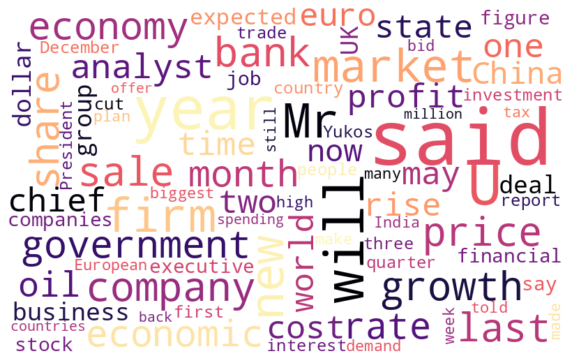



Word Cloud For entertainment 



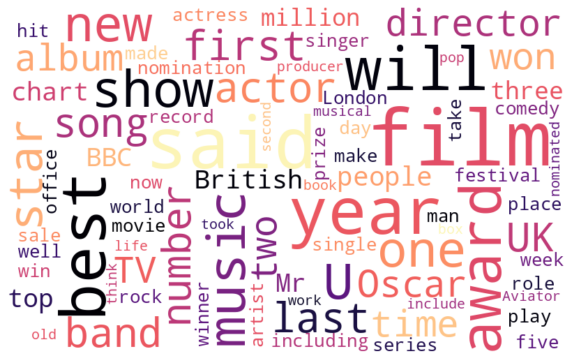



Word Cloud For politics 



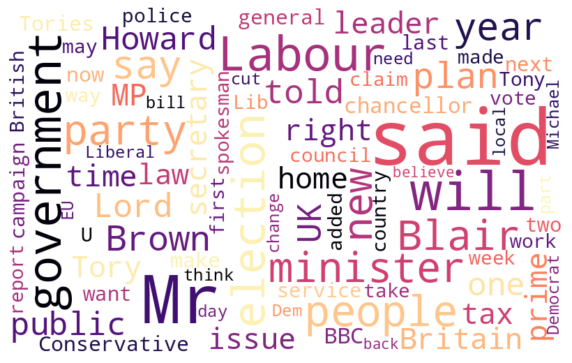



Word Cloud For sport 



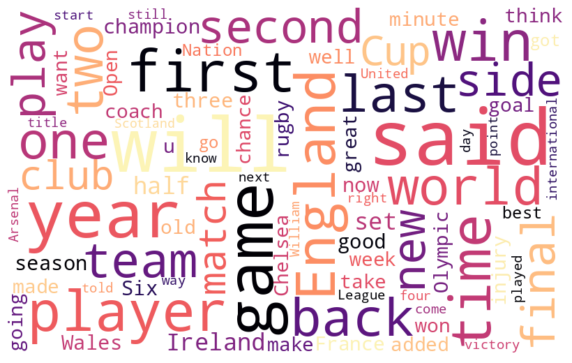



Word Cloud For tech 



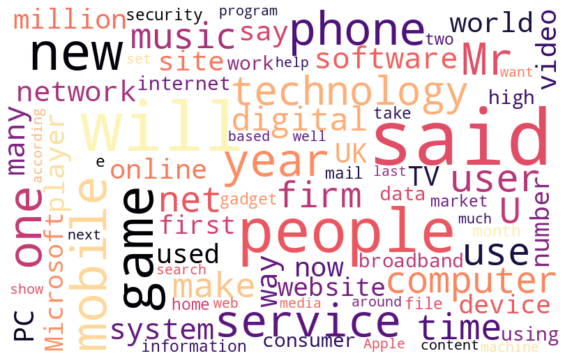

In [6]:
# Creating Word Cloud & Visualizing Important Keywords

def create_wordcloud(words):
    wordcloud = WordCloud(width=800, height=500,colormap='magma', random_state=30, max_font_size=110,collocations=False, background_color='white', max_words= 80).generate(words)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()
    
plt.figure(figsize = (16,9),dpi=300)
for i,col in enumerate(['business','entertainment','politics','sport','tech']):
    print('\033[1m\n\nWord Cloud For', col,'\n\033[0m')
    subset=bbc_df[bbc_df.Category==col]
    text=subset.News.values
    words =" ".join(text)
    create_wordcloud(words)
plt.show()

### DATA PRE-PROCESSING

In [7]:
# DATA CLEANING
print('\033[1mData cleaning in progress...\n\033[0m')

# Tokenize
bbc_df['Cleaned Text'] = bbc_df['News'].apply(nltk.word_tokenize)
print('Tokenization complete.\n')

# Remove stop words
stop_words=set(nltk.corpus.stopwords.words("english"))
bbc_df['Cleaned Text'] = bbc_df['Cleaned Text'].apply(lambda x: [item for item in x if item not in stop_words])
print('Stop words removed.\n')

# Remove numbers, punctuation and special characters (only keep words)
regex = '[a-z]+'
bbc_df['Cleaned Text'] = bbc_df['Cleaned Text'].apply(lambda x: [item for item in x if re.match(regex, item)])
print('Numbers, punctuation and special characters removed.\n')

# Lemmatization
lem = nltk.stem.wordnet.WordNetLemmatizer()
bbc_df['Cleaned Text'] = bbc_df['Cleaned Text'].apply(lambda x: [lem.lemmatize(item, pos='v') for item in x])
print('Lemmatization complete.\n.\n.\n.\n\033[1mData cleaning complete.\n\033[0m')

# Now Checking the new dataset
bbc_df.head(10)

Data cleaning in progress...

Tokenization complete.

Stop words removed.

Numbers, punctuation and special characters removed.

Lemmatization complete.
.
.
.
Data cleaning complete.



,No,News,Category,News_length,Cleaned Text
0,1,Ad sales boost Time Warner profit Quarterly p...,business,2559,"[sales, boost, profit, profit, media, giant, j..."
1,2,Dollar gains on Greenspan speech The dollar h...,business,2252,"[gain, speech, dollar, hit, highest, level, eu..."
2,3,Yukos unit buyer faces loan claim The owners ...,business,1551,"[unit, buyer, face, loan, claim, owners, embat..."
3,4,High fuel prices hit BA's profits British Air...,business,2401,"[fuel, price, hit, profit, blame, high, fuel, ..."
4,5,Pernod takeover talk lifts Domecq Shares in U...,business,1569,"[takeover, talk, lift, drink, food, firm, rise..."
5,6,Japan narrowly escapes recession Japan's econ...,business,1187,"[narrowly, escape, recession, economy, teeter,..."
6,7,Jobs growth still slow in the US The US creat...,business,1669,"[growth, still, slow, create, fewer, job, expe..."
7,8,India calls for fair trade rules India which...,business,1922,"[call, fair, trade, rule, attend, meet, seven,..."
8,9,Ethiopia's crop production up 24% Ethiopia pr...,business,1494,"[crop, production, produce, million, tonnes, c..."
9,10,Court rejects $280bn tobacco case A US govern...,business,1448,"[reject, tobacco, case, government, claim, acc..."


### FEATURE ENGINEERING | MODEL CREATION | TRAINING | PREDICTIONS | PERFORMANCE

In [8]:
# Creating Class for Vectorizer
class Vectorizer(object):
    
    def __init__(self, vec):
        self.vec = vec
        self.dim = len(vec.values())

    def fit(self, X, y):
        return self

    def transform(self, X):
        return np.array([np.mean([self.vec[w] for w in words if w in self.vec] or [np.zeros(self.dim)], axis=0) for words in X])


# Creating Class for Classifier    
class Classifier(object):
    
    def __init__(self, model, param):
        self.model = model
        self.param = param
        self.gs = GridSearchCV(self.model, self.param, cv=5, error_score=0, refit=True)        

    def fit(self, X, y):        
        return self.gs.fit(X, y)

    def predict(self, X):
        return self.gs.predict(X)


# Defining Models    
clf_models = {
    'Naive Bayes': GaussianNB(), 
    'SVC': SVC(),
    'Decision Tree': DecisionTreeClassifier(),  
    'Perceptron': MLPClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}


# Defining Model Parameters
clf_params = {
    'Naive Bayes': { }, 
    'SVC': { 'kernel': ['linear', 'rbf'] },
    'Decision Tree': { 'min_samples_split': [2, 5] }, 
    'Perceptron': { 'activation': ['tanh', 'relu'] },
    'Gradient Boosting': { 'min_samples_split': [2, 5] }
}

# Splitting Testing and Training Dataset
X_train, X_test, y_train, y_test = train_test_split(bbc_df['News'], bbc_df['Category'], test_size=0.2, shuffle=True)


##### Classification using unigrams TF-IDF vectorizer

Vectorization complete.

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Precision: 0.953 	Recall: 0.960 		F1: 0.955



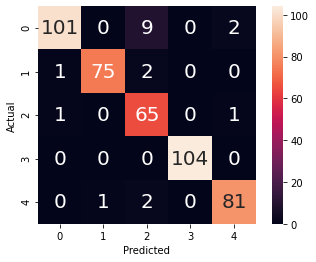

Decision Tree : {'min_samples_split': 2}
Precision: 0.798 	Recall: 0.803 		F1: 0.796



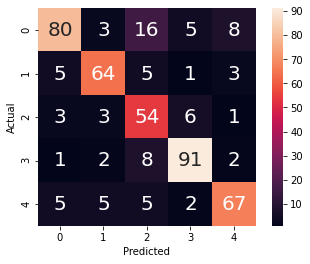

In [9]:
# Classification using unigrams TF-IDF vectorizer

# Vectorize training and testing data

def Vectorize(vec, X_train, X_test):    
    
    X_train_vec = vec.fit_transform(X_train)
    X_test_vec = vec.transform(X_test)
    
    print('Vectorization complete.\n')
    
    return X_train_vec, X_test_vec

Result= pd.DataFrame()
Result['Actual Values']= y_test

# Use multiple classifiers and grid search for prediction
def ML_modeling(models, params, X_train, X_test, y_train, y_test):

    if not set(models.keys()).issubset(set(params.keys())):
        raise ValueError('Some estimators are missing parameters')

    for key in models.keys():
    
        model = models[key]
        param = params[key]
        gs = GridSearchCV(model, param, cv=5, error_score=0, refit=True, return_train_score=True)
        gs.fit(X_train, y_train)
        y_pred = gs.predict(X_test)
        Result[models[key]]= y_pred
        matrix=confusion_matrix(y_test,y_pred)
        
        # Print scores for the classifier
        print(key, ':', gs.best_params_)
        print("Precision: %1.3f \tRecall: %1.3f \t\tF1: %1.3f\n" % (precision_score(y_test, y_pred, average='macro'),
                                                                    recall_score(y_test, y_pred, average='macro'),
                                                                    f1_score(y_test, y_pred, average='macro')))

        sns.heatmap(matrix,annot=True, annot_kws={'size':20}, square=True,fmt='.0f')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()
    
    return

models = {
    'Naive Bayes': MultinomialNB(), 
    'Decision Tree': DecisionTreeClassifier(),  
    #'Perceptron': MLPClassifier(),
    #'Gradient Boosting': GradientBoostingClassifier()
}

params = {
    'Naive Bayes': { 'alpha': [0.5, 1], 'fit_prior': [True, False] }, 
    'Decision Tree': { 'min_samples_split': [1, 2, 5] }, 
    'Perceptron': { 'alpha': [0.0001], 'activation': ['relu'] },
    'Gradient Boosting': { 'learning_rate': [0.05, 0.1], 'min_samples_split': [2, 5] }
}

# Encode label categories to numbers
enc = LabelEncoder()
bbc_df['Category'] = enc.fit_transform(bbc_df['Category'])
labels = list(enc.classes_)

# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(bbc_df['News'], bbc_df['Category'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(ngram_range=(1,1)), X_train, X_test,)


ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

In [10]:
# Results for Classification using unigrams TF-IDF vectorizer

interpretation={}
i=0
for value in labels:
    interpretation.update({value:i})
    i=i+1
    
print('INTERPRETATION\n\n',interpretation,'\n')
print('\n\n\033[1m--------Prediction Result Comparison Table-------\033[0m')
Result.sort_index(ascending=True)

INTERPRETATION

 {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4} 



--------Prediction Result Comparison Table-------


,Actual Values,MultinomialNB(),DecisionTreeClassifier()
4,business,2,2
6,business,3,2
9,business,2,2
16,business,0,2
17,business,2,2
...,...,...,...
2213,tech,2,2
2214,tech,3,3
2219,tech,4,4
2221,tech,0,0


##### Classification using N-grams TF vectorizer

Vectorization complete.

Naive Bayes : {'alpha': 0.5, 'fit_prior': False}
Precision: 0.965 	Recall: 0.964 		F1: 0.963



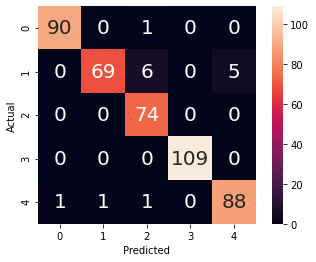

Decision Tree : {'min_samples_split': 5}
Precision: 0.805 	Recall: 0.809 		F1: 0.806



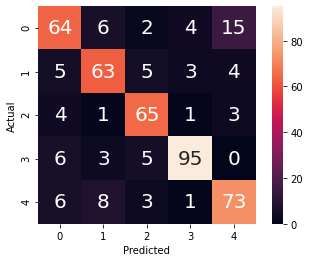

In [11]:
# Classification using N-grams TF vectorizer

# Train-test split and vectorize
X_train, X_test, y_train, y_test = train_test_split(bbc_df['News'], bbc_df['Category'], test_size=0.2, shuffle=True)
X_train_vec, X_test_vec = Vectorize(TfidfVectorizer(ngram_range=(1,2)), X_train, X_test,)

ML_modeling(models, params, X_train_vec, X_test_vec, y_train, y_test)

In [12]:
# Results for Classification using N-grams TF vectorizer

print('INTERPRETATION\n\n',interpretation,'\n')
print('\n\n\033[1m--------Prediction Result Comparison Table-------\033[0m')
Result.sort_index(ascending=True)

INTERPRETATION

 {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4} 



--------Prediction Result Comparison Table-------


,Actual Values,MultinomialNB(),DecisionTreeClassifier()
4,business,0,3
6,business,4,4
9,business,0,3
16,business,4,4
17,business,2,2
...,...,...,...
2213,tech,0,4
2214,tech,3,3
2219,tech,4,4
2221,tech,4,4
